# Homework 6

Our goal is to plot various quantities from MESA stellar evolution models of 1, 8, and 15 $M_\odot$ stars.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We'll make some classes to store the data from the model files.  

In [2]:
class Profile:
    def __init__(self, pfile):
        p = np.loadtxt(pfile)
        self.r = p[:,0]
        self.m = p[:,1]
        self.rho = p[:,2]
        self.T = p[:,3]
        self.P = p[:,4]
        self.mu = p[:,5]
        self.mu_e = p[:,6]
        self.L = p[:,7]
        self.X = p[:,8]
        self.Y = p[:,9]
        self.grad_a = p[:,10]
        self.grad_T = p[:,11]
        self.q = p[:,12]
        
        # the age is specified on the first line
        with open(pfile) as pf:
            line = pf.readline()
            self.age = line.split("=")[-1].split()[0]

In [3]:
class History:
    def __init__(self, hfile):
        h = np.loadtxt(hfile)
        self.age = h[:,0]
        self.mass = h[:,1]
        self.rho_c = h[:,2]
        self.T_c = h[:,3]
        self.T_eff = h[:,4]
        self.L = h[:,5]
        self.X = h[:,6]
        self.mu = h[:,7]

In [4]:
class Model:
    def __init__(self, mass, profiles=None, history=None):
        self.mass = mass
        if history:
            self.history = History(history)
        self.profiles = []
        if profiles:
            for p in profiles:
                self.profiles.append(Profile(p))


Now read in all the data

In [5]:
models = []

models.append(Model(1, profiles=["M1.0_profile_H_simple.out", "M1.0_profile_He_simple.out"],
                    history="M1.0_history_simple.out"))

models.append(Model(8, profiles=["M8.0_profile_H_simple.out", "M8.0_profile_He_simple.out"],
                    history="M8.0_history_simple.out"))

models.append(Model(15, profiles=["M15.0_profile_H_simple.out", "M15.0_profile_He_simple.out"],
                    history="M15.0_history_simple.out"))

Fundamental constants

In [6]:
# CGS constants
k_B = 1.38e-16
m_u = 1.66e-24
m_e = 9.11e-28
c = 3.e10
h = 6.63e-27
a = 5.67e-15

## 1. a. HR diagram

Now we'll make an HR diagram and label the points where $H$ and $He$ burning commences.

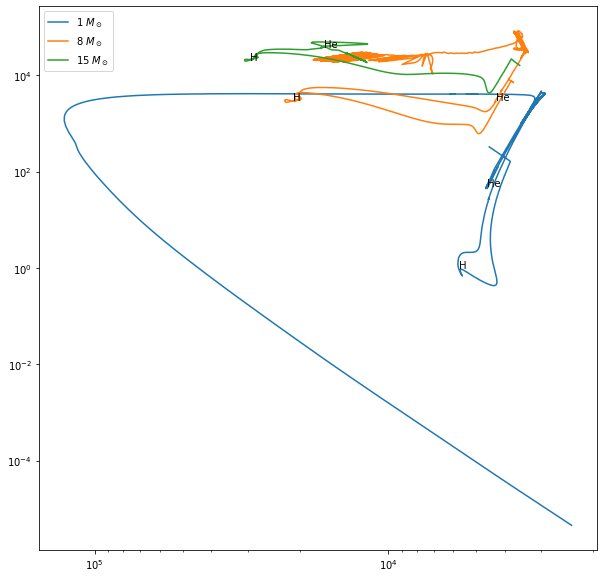

In [7]:
fig, ax = plt.subplots()

for star in models:
    ax.loglog(star.history.T_eff, star.history.L,
              label=rf"{star.mass} $M_\odot$")
    ih = np.where(star.history.age < float(star.profiles[0].age))[0][0]
    ax.text(star.history.T_eff[ih], star.history.L[ih], "H")
    ihe = np.where(star.history.age < float(star.profiles[1].age))[0][0]
    ax.text(star.history.T_eff[ihe], star.history.L[ihe], "He")

ax.legend()
ax.invert_xaxis()
fig.set_size_inches((10, 10))

You can see the main sequence clearly on this plot simply by connecting the points marked "H".  We also see that only the 1 solar mass star "finished' stellar evolution, winding up as a cooling white dwarf at the end -- the path it is following is essentially a line of constant radius, since the white dwarf does not contract as it cools (it is degenerate).

## 1. b. central evolution

First well find the boundary where degeneracy (NR) and ideal gas balance:

$$\frac{\rho k_B T}{\mu m_u} = \frac{h^2}{20m_e} \left (\frac{3}{\pi}\right )^{2/3} \frac{1}{(\mu_e m_u)^{5/3}} \rho^{5/3}$$

We'll write a function that returns $\rho$ given $T$:

In [8]:
def rho_ideal_deg(T, mu=0.6, mu_e=1.3):
    return ((k_B*T/(mu*m_u))/(h**2/(20*m_e)*(3/np.pi)**(2./3.)/(mu_e*m_u)**(5./3.)))**(3./2.)

Next the boundary where radition and idea gas balance:

$$\frac{\rho k_B T}{\mu m_u} = \frac{1}{3}a T^4$$

In [9]:
def rho_ideal_rad(T, mu=0.6):
    return a*T**3*mu*m_u/(3*k_B)

Now we can plot the data

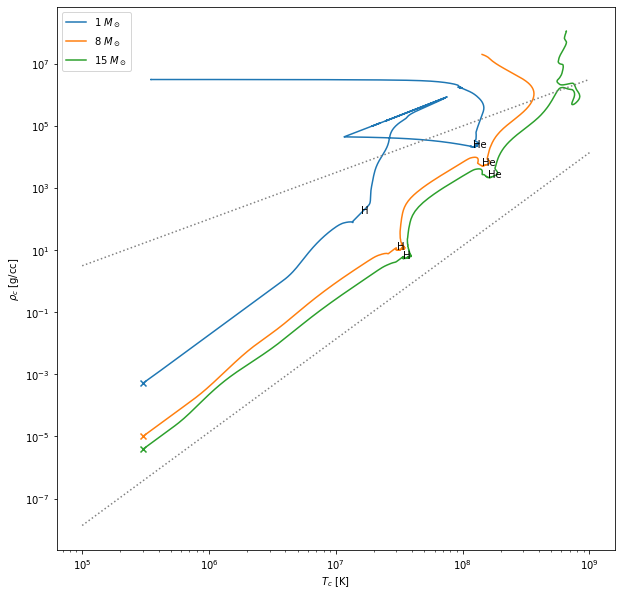

In [10]:
fig, ax = plt.subplots()

for star in models:
    ax.loglog(star.history.T_c, star.history.rho_c,
              label=rf"{star.mass} $M_\odot$")
    ax.scatter(star.history.T_c[-1], star.history.rho_c[-1], marker="x")
    ih = np.where(star.history.age < float(star.profiles[0].age))[0][0]
    ax.text(star.history.T_c[ih], star.history.rho_c[ih], "H")
    ihe = np.where(star.history.age < float(star.profiles[1].age))[0][0]
    ax.text(star.history.T_c[ihe], star.history.rho_c[ihe], "He")
T = np.logspace(5,9,100)
ax.loglog(T, rho_ideal_deg(T), color="0.5", ls=":")
ax.loglog(T, rho_ideal_rad(T), color="0.5", ls=":")
ax.legend()

ax.set_xlabel(r"$T_c$ [K]")
ax.set_ylabel(r"$\rho_c$ [g/cc]")
fig.set_size_inches((10, 10))

Comparing to the plots in chapter 7, we see the behaviour we expect.  The higher mass stars are closer to the line where radiation dominates.  The 1 solar mass star makes a transition from following $T \approx \rho^{1/3}$ to $\rho = \mbox{constant}$ when degeneracy kicks in.  The other stars more or less follow the $T \approx \rho^{1/3}$ trend expected from polytropes + ideal gas.

The points labeled H and He are in the middle of those core burning phases.

We can actually add the ignition curves that we did in homework 5 to these plots!

In [11]:
def q_H(T, X=0.7, Z=0.02, q_min=1.e3):
    """return the density for the given temperature for H burning"""
    
    # we have either pp or CNO here
    # we write q_pp = rho A
    # we write q_CNO = rho B
    T_9 = T/1.e9
    A = 2.4e4*X**2*T_9**(-2./3.)*np.exp(-3.38/T_9**(1./3.))
    B = 4.4e25*X*Z*T_9**(-2./3.)*np.exp(-15.228/T_9**(1./3.))
    
    C = A + B
    # take which ever is larger
    #C = np.where(A > B, A, B)
    
    return q_min/C

def q_He(T, Y=1.0, q_min=1.e3):
    """return the density for a given temperature for He burning"""
    
    T_8 = T/1.e8
    A = 5.09e11*Y**3*T_8**(-3)*np.exp(-44.027/T_8)
    return np.sqrt(q_min/A)

T_H = np.logspace(6.8,7.5,100)
rho_H = q_H(T_H, q_min=1.e2)

T_He = np.logspace(7.9,8.3,100)
rho_He = q_He(T_He)

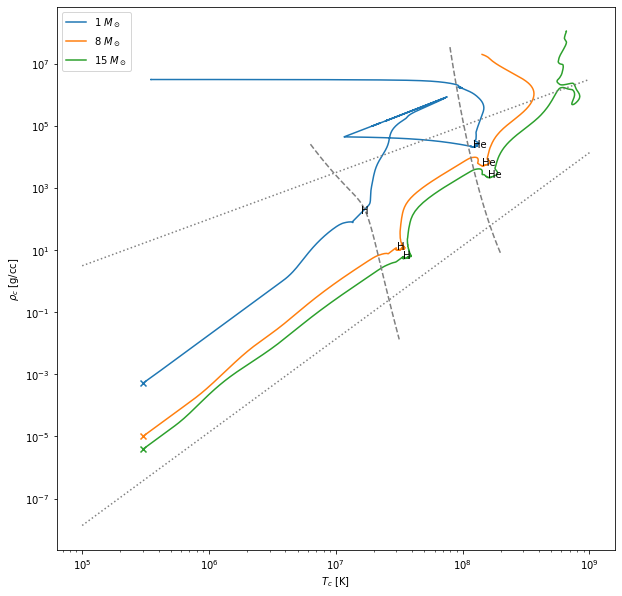

In [12]:
ax.plot(T_H, rho_H, ls="--", color="0.5")
ax.plot(T_He, rho_He, ls="--", color="0.5")

fig

## 1. c. Main sequence lifetime

We can estimate the main sequence lifetime just by looking for when the core H is all consumed.

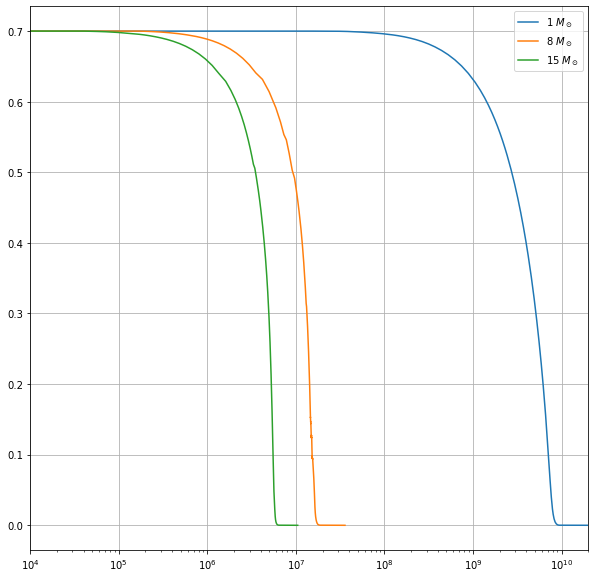

In [13]:
fig, ax = plt.subplots()
for star in models:
    ax.semilogx(star.history.age, star.history.X, label=rf"{star.mass} $M_\odot$")
ax.legend()
ax.grid()
ax.set_xlim(1.e4, 2.e10)
fig.set_size_inches(10, 10)

From this plot, we see that the main sequence lifetime of the 15 $M_\odot$ star is $\sim 6\times 10^6$ yr, for the 8 $M_\odot$ star $\sim 2\times 10^7$ yr, and for the 1 $M_\odot$ star $\sim 9\times 10^9$ yr.

## 2. a. Eddington Standard Model

The Eddington standard model works for a fully radiative star with a constant composition.

In class, we found that the temperature and density in the Eddington standard model were related by

$$T(r) = 4.62\times 10^6 \beta\mu \left ( \frac{M}{M_\odot} \right)^{2/3} \rho^{1/3}(r)$$

We will assume that $\mu$ is constant and take $\mu$ and $\beta$ from the center of the star.

Here's a function to compute $\beta$

In [14]:
def get_beta(profile):
    """compute the raito of gas to total pressure"""
    P_g = profile.rho[0] * k_B * profile.T[0] / (profile.mu[0] * m_u)
    beta = P_g / profile.P[0]
    return beta

and here's a function to return the $T(\rho)$ curve predicted by the Eddington standard model.

In [15]:
def eddington_T(rho, beta, mu, M):
    return 4.62e6 * beta * mu * M**(2./3.) * rho**(1./3.)

For convection, we need $\nabla > \nabla_\mathrm{ad}$.  We have those quantities in the model files.

Here's our plotting function.  We will plot the data from the MESA model and the line corresponding to the Eddington standard model.  We will also mark those zones in the MESA model where $\nabla > \nabla_\mathrm{ad}$ with red squares, to indicate that it is convective.

In [18]:
def make_plot(profile, beta, M):
    fig, ax = plt.subplots()
    ax.loglog(profile.T, profile.rho)
    
    # find where it is convective
    idx = profile.grad_T >= profile.grad_a
    ax.scatter(profile.T[idx], profile.rho[idx],
               color="r", marker="s", alpha=0.5, linewidth=3)
    ax.loglog(eddington_T(profile.rho, beta, profile.mu[0], M), profile.rho,
              ls=":", label="Eddington standard model")
    ax.legend()
    ax.set_xlabel("T [K]")
    ax.set_ylabel("rho [g/cc]")
    ax.set_title(rf"M = {M} $M_\odot$; age = {profile.age} years")

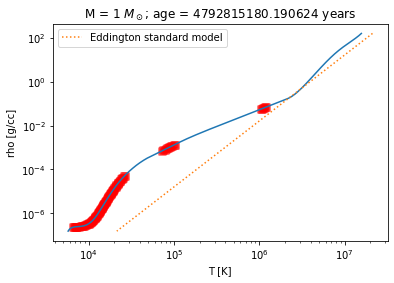

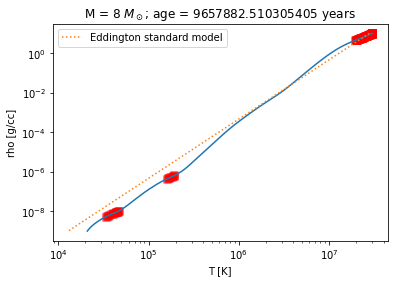

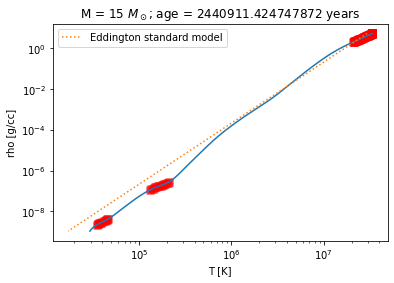

In [19]:
for star in models:
    M = star.mass
    p = star.profiles[0]
    beta = get_beta(p)

    fig = make_plot(p, beta, M)

Looking at these plots, keep in mind that the center of the star is in the upper right.  We see that:

* For the 1 $M_\odot$ star, since the core is radiative, we match well up util we first become convective.
* For the 2 more massive stars, there are small convective cores and then radiative envelopes, and the Eddington standard
  model does well for most of the radiative envelope.

## (b) He flash

A helium flash occurs when we ignite core He burning under degenerate conditions.  We'll use the same line derived up in Q1 to define degeneracy.

Now we'll plot all of the He-burning models together with the line indicating degeneracy.  We will assume that the composition is pure He, which has $\mu = 4/3$, $\mu_e = 2$

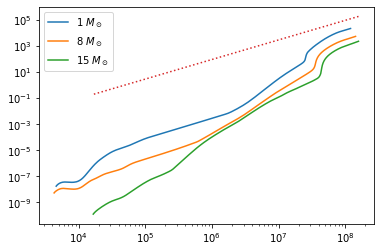

In [20]:
fig, ax = plt.subplots()
for star in models:
    M = star.mass
    p = star.profiles[1]
    ax.loglog(p.T, p.rho, label=rf"{M} $M_\odot$")
rho = np.logspace(-7, 5, 100)
ax.loglog(p.T, rho_ideal_deg(p.T, mu=4/3, mu_e=2), ls=":")
ax.legend()

We see that the 1 $M_\odot$ model comes closest to the degeneracy line, so this is the only model where we might expect a He flash to occur (we note that these models are from the point when core He burning was already midway through, not at ignition).